<a href="https://colab.research.google.com/github/edsondamasceno/Data-Analysis/blob/main/Heart_Failure_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

import xgboost as xgb

## Carregando os dados

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Data Analysis/Dataset/heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [ ]:
#Gerando uma copia do dataset
df_copy = df.copy()

df_copy.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


## Realizando pré-processamento nos dados

In [ ]:
# verificando zeros
(df[['RestingBP', 'Cholesterol']] == 0).sum()

,0
RestingBP,1
Cholesterol,172


Valores zero para pressão arterial e colesterol não são válidos e precisam ser corrigidos. Os valores de colesterol serão substituídos pela mediana considerando sexo e gênero. Já a pressão arterial será ajustada usando a média.

In [ ]:
df['Cholesterol'] = df['Cholesterol'].replace(0, np.nan)
df['RestingBP'] = df['RestingBP'].replace(0, np.nan)

df['RestingBP'] = df['RestingBP'].fillna(df['RestingBP'].mean())
df['Cholesterol'] = df.groupby(['Age', 'Sex'])['Cholesterol'].transform(lambda x: x.fillna(x.median()))

df['Cholesterol'] = df['Cholesterol'].fillna(df['Cholesterol'].median())

df.isna().sum()

,0
Age,0
Sex,0
ChestPainType,0
RestingBP,0
Cholesterol,0
FastingBS,0
RestingECG,0
MaxHR,0
ExerciseAngina,0
Oldpeak,0


array([[<Axes: title={'center': 'RestingBP'}>,
        <Axes: title={'center': 'Cholesterol'}>]], dtype=object)

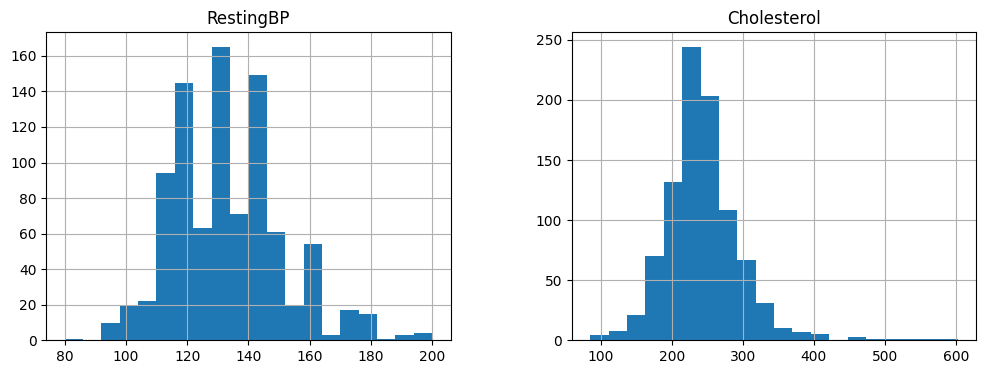

In [ ]:
# verificar histórico de BP e colesterol
df.hist(column = ['RestingBP', 'Cholesterol'], bins = 20, figsize = (12, 4))

<Axes: >

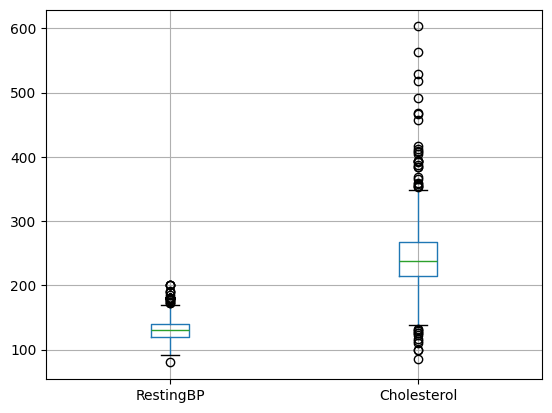

In [ ]:
# Boxplot
df.boxplot(column = ['RestingBP', 'Cholesterol'])

## Codificação de valores categóricos

In [ ]:
cat_columns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
df[cat_columns].nunique()

le = LabelEncoder()

df['Sex'] = le.fit_transform(df['Sex'])
df['ExerciseAngina'] = le.fit_transform(df['ExerciseAngina'])
df = pd.get_dummies(df, columns = ['ChestPainType', 'RestingECG', 'ST_Slope'], drop_first=True)

In [ ]:
df.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ST_Slope_Flat,ST_Slope_Up
0,40,1,140.0,289.0,0,172,0,0.0,0,True,False,False,True,False,False,True
1,49,0,160.0,180.0,0,156,0,1.0,1,False,True,False,True,False,True,False
2,37,1,130.0,283.0,0,98,0,0.0,0,True,False,False,False,True,False,True
3,48,0,138.0,214.0,0,108,1,1.5,1,False,False,False,True,False,True,False
4,54,1,150.0,195.0,0,122,0,0.0,0,False,True,False,True,False,False,True


## Análise Exploratória de Dados

Text(0.5, 1.0, 'Distribuição das Doenças Cardíacas')

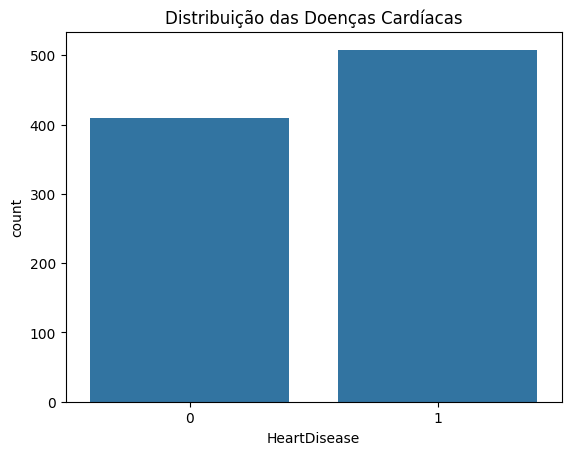

In [ ]:
target_col = 'HeartDisease'

sns.countplot(x = target_col, data = df)
plt.title('Distribuição das Doenças Cardíacas')

Text(0.5, 1.0, 'Matriz de Correlação')

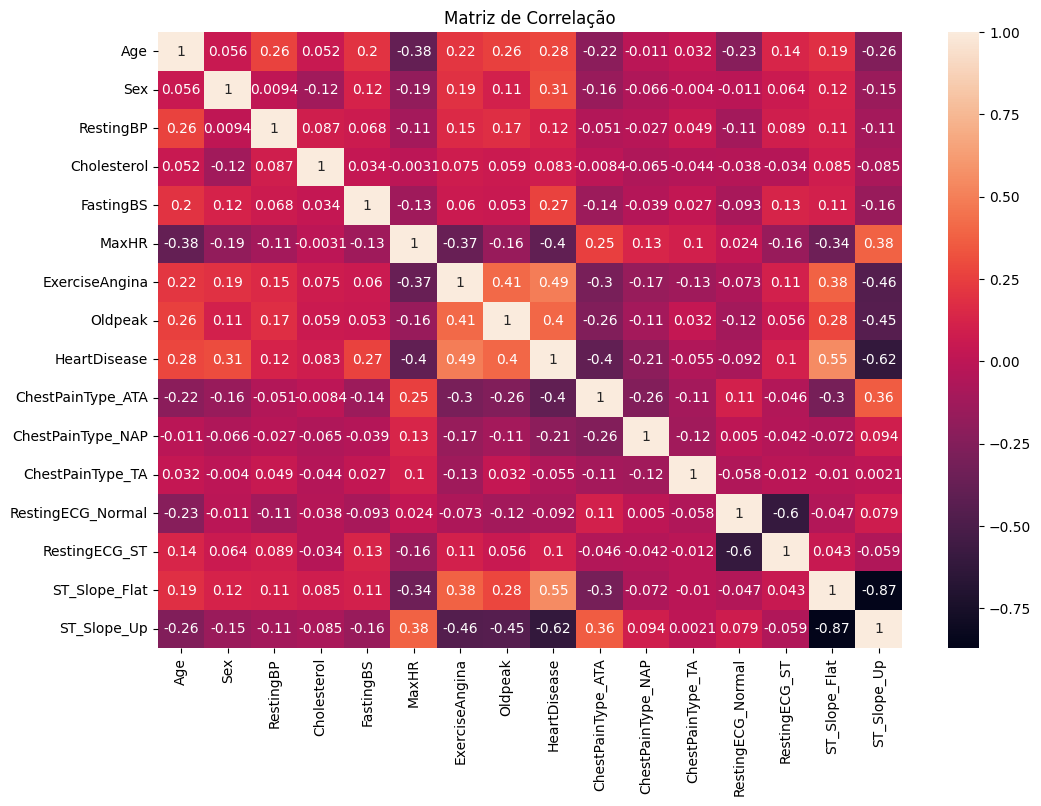

In [ ]:
#Matriz de correlação
plt.figure(figsize = (12, 8))

corr = df.corr()

sns.heatmap(corr, annot=True)
plt.title('Matriz de Correlação')

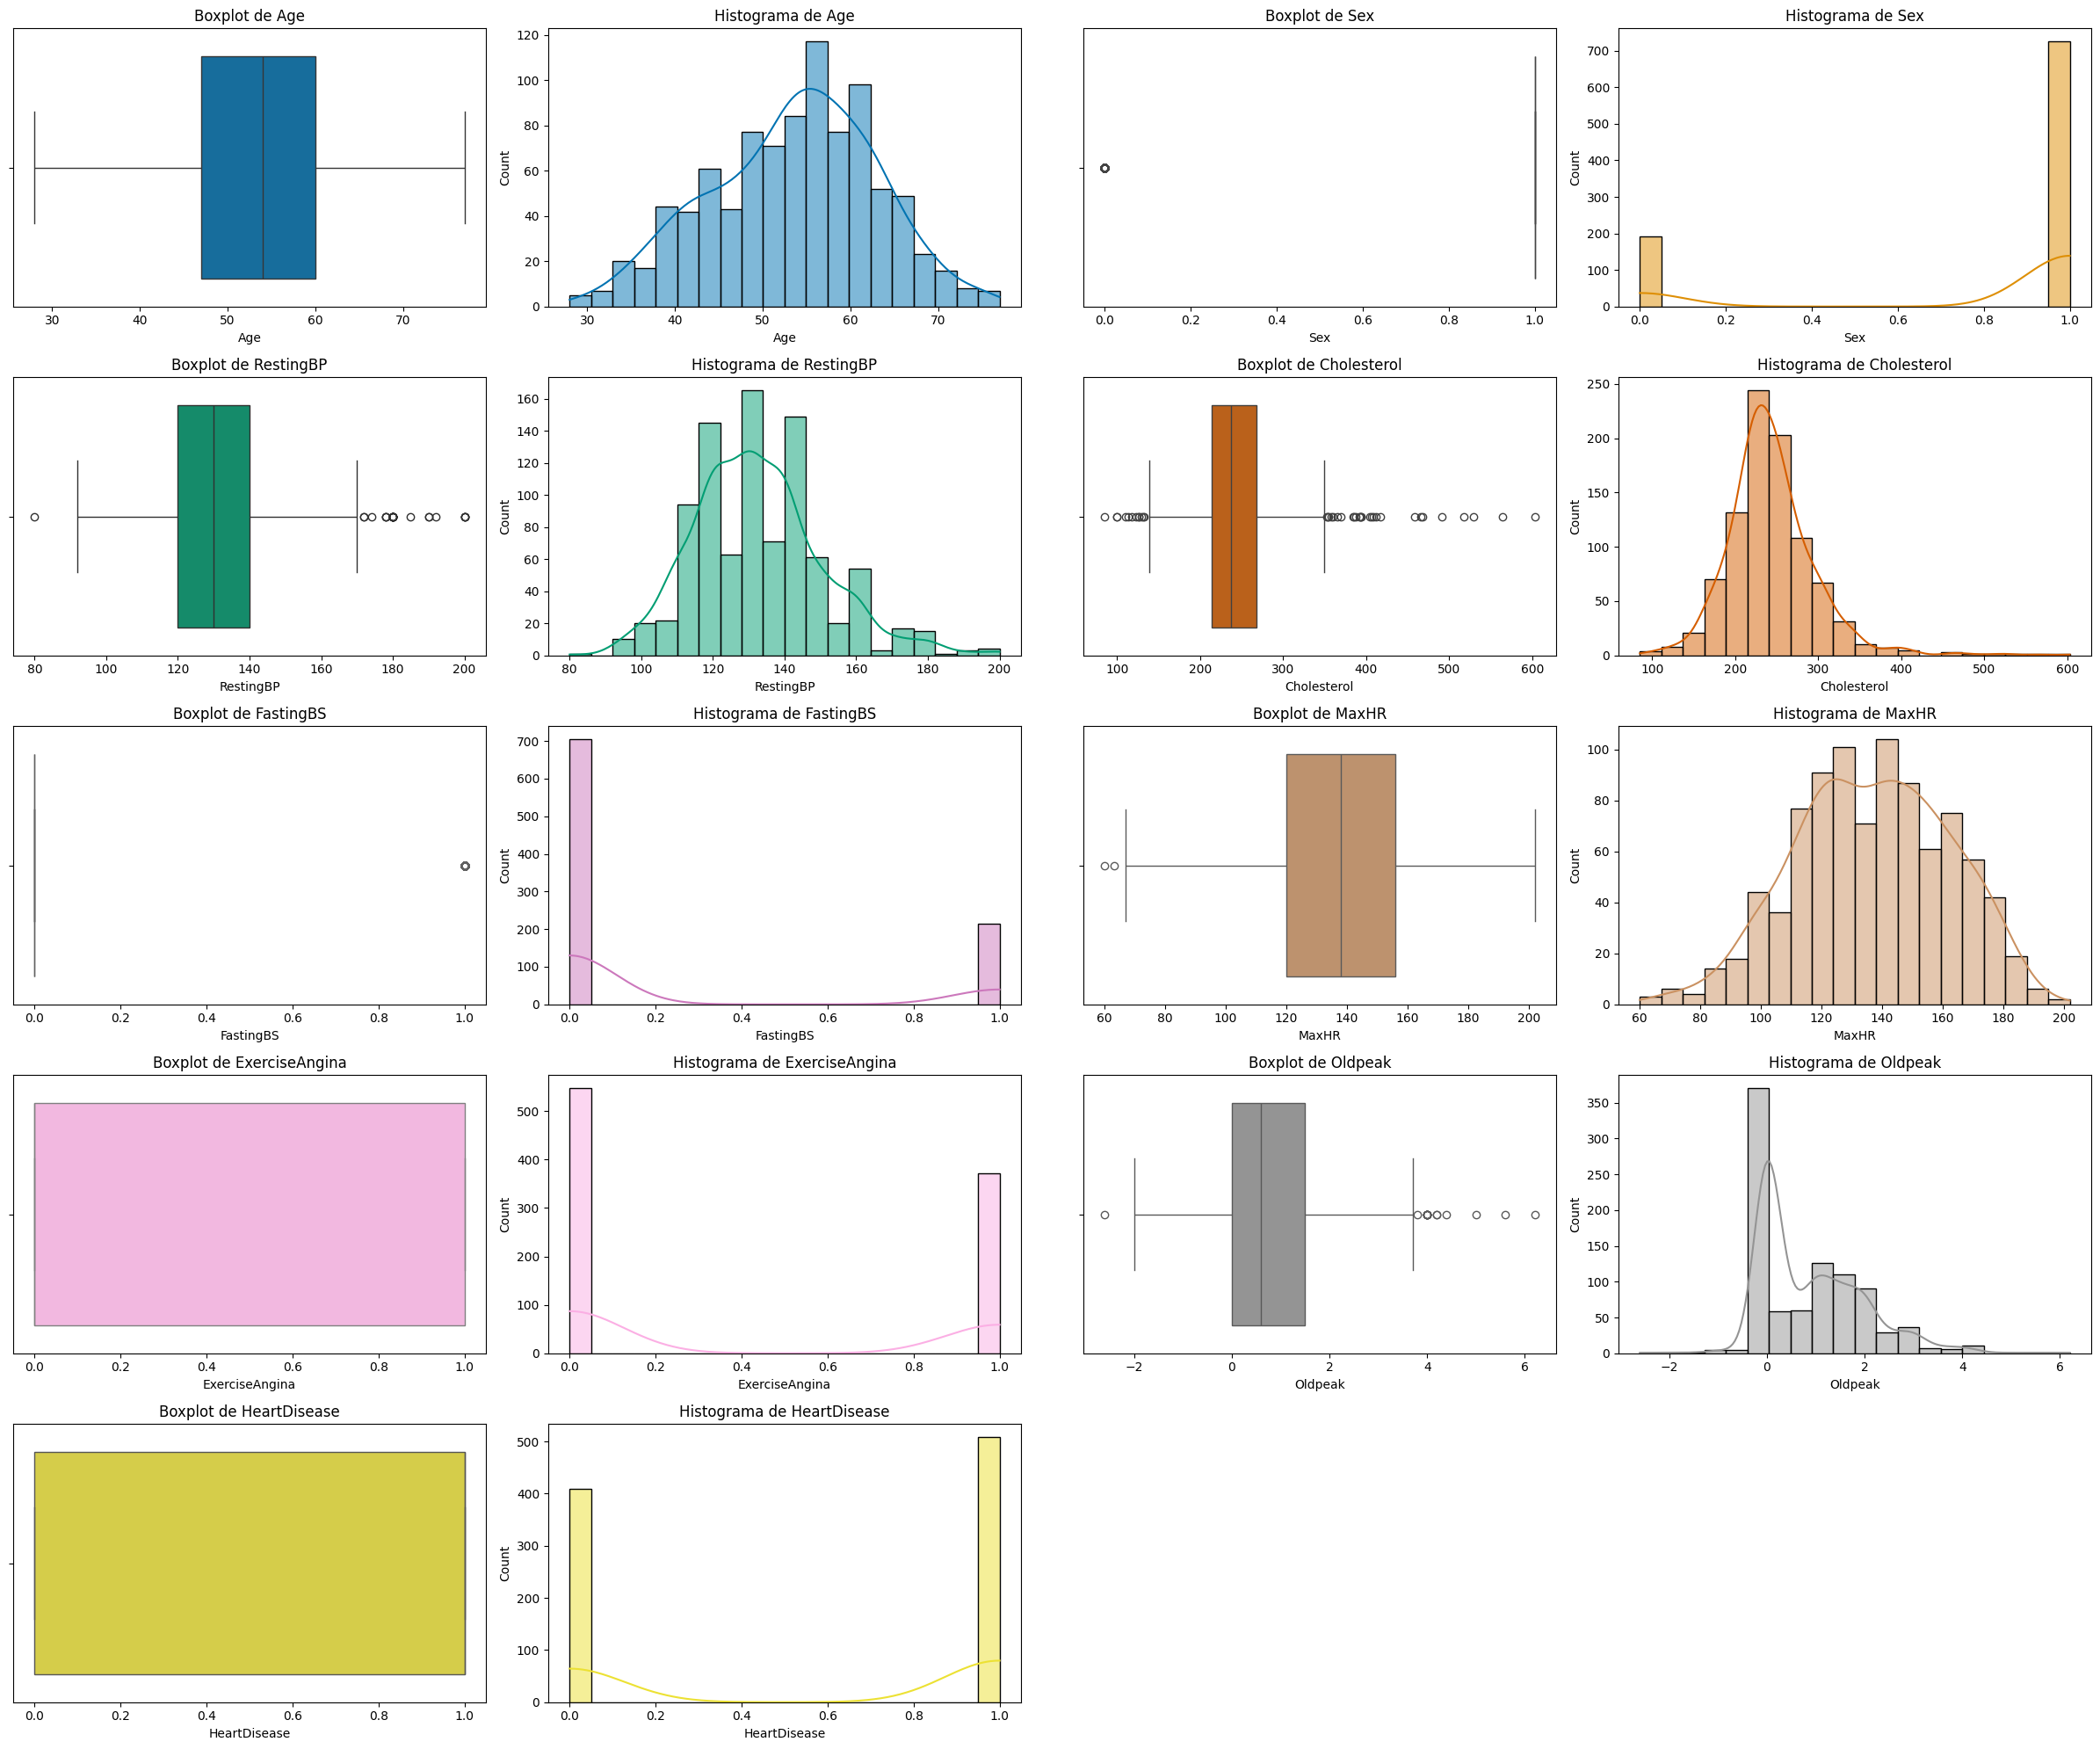

In [ ]:
# Selecione colunas numéricas
num_cols = df.select_dtypes(include=['int32', 'int64', 'float64', 'object']).columns

# Atribuir paleta de cores
colors = sns.color_palette('colorblind', n_colors=len(num_cols))

# Cada característica utiliza 2 colunas (box + hist) → total de colunas = 4
ncols = 4
nrows = (len(num_cols) * 2 + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 4*nrows))
axes = axes.flatten()

plot_idx = 0
for col, color in zip(num_cols, colors):
    # Boxplot
    sns.boxplot(x=df[col], ax=axes[plot_idx], color=color)
    axes[plot_idx].set_title(f'Boxplot de {col}')
    plot_idx += 1

    # Histograma
    sns.histplot(df[col], bins=20, kde=True, ax=axes[plot_idx], color=color)
    axes[plot_idx].set_title(f'Histograma de {col}')
    plot_idx += 1

# Remova os eixos não utilizados
for j in range(plot_idx, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Relação de características

Text(0.5, 1.0, 'Oldpeak vs HeartDisease')

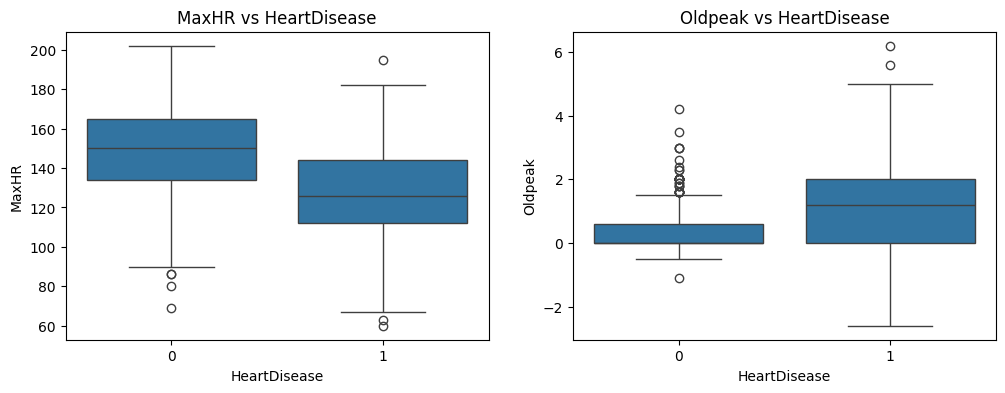

In [ ]:
# Verificar a dependência da HR máxima, do pico antigo e do alvo.
fig, axes = plt.subplots(1, 2, figsize = (12,4))

sns.boxplot(x = 'HeartDisease', y = 'MaxHR', data = df, ax = axes[0])
axes[0].set_title('MaxHR vs HeartDisease')

sns.boxplot(x = 'HeartDisease', y = 'Oldpeak', data = df, ax = axes[1])
axes[1].set_title('Oldpeak vs HeartDisease')

Text(0.5, 1.0, 'Frequência de doenças cardíacas para a inclinação do segmento ST')

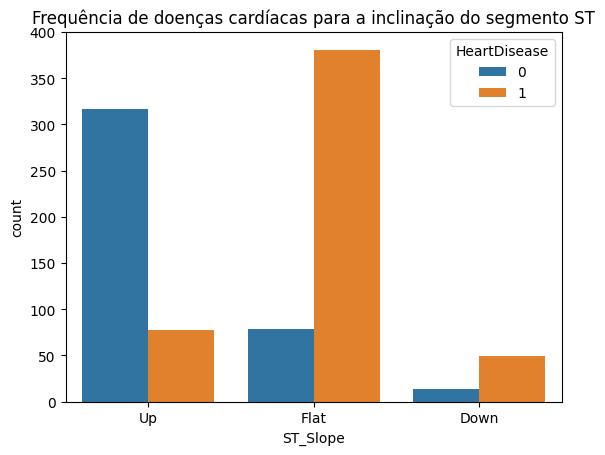

In [ ]:
# Inclinação ST e alvo
sns.countplot(x = 'ST_Slope', hue = 'HeartDisease', data = df_copy)
plt.title('Frequência de doenças cardíacas para a inclinação do segmento ST')

## Engenharia de Características

<Axes: >

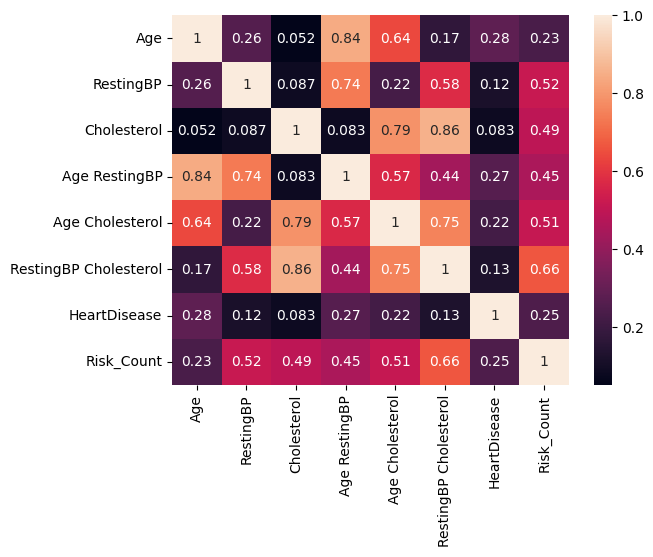

In [ ]:
# verificando a correlação da combinação das características
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

poly_array = poly.fit_transform(df[['Age', 'RestingBP', 'Cholesterol']])
features = poly.get_feature_names_out(['Age', 'RestingBP', 'Cholesterol'])

df_poly = pd.DataFrame(poly_array, columns=features)

df_poly['HeartDisease'] = df['HeartDisease']
df_poly['Risk_Count'] = (
    (df['RestingBP'] > 140).astype(int) +
    (df['Cholesterol'] > 240).astype(int) +
    (df['Oldpeak'] > 2).astype(int)
)

corrs = df_poly.corr()

sns.heatmap(corrs, annot=True)

In [ ]:
# adicionar recurso de contagem de risco
df['RiskCnt'] = (
    (df['RestingBP'] > 140).astype(int) +
    (df['Cholesterol'] > 240).astype(int) +
    (df['Oldpeak'] > 2).astype(int)
)

In [ ]:
# Convertendo bool -> int
df = df.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)
df.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ST_Slope_Flat,ST_Slope_Up,RiskCnt
0,40,1,140.0,289.0,0,172,0,0.0,0,1,0,0,1,0,0,1,1
1,49,0,160.0,180.0,0,156,0,1.0,1,0,1,0,1,0,1,0,1
2,37,1,130.0,283.0,0,98,0,0.0,0,1,0,0,0,1,0,1,1
3,48,0,138.0,214.0,0,108,1,1.5,1,0,0,0,1,0,1,0,0
4,54,1,150.0,195.0,0,122,0,0.0,0,0,1,0,1,0,0,1,1


In [ ]:
# Adicionando novas características
def update_features(X):
    X_cp = X.copy()
    X_cp['AgeBP'] = X_cp['Age'] * X_cp['RestingBP']
    X_cp['AgeCholesterol'] = X_cp['Age'] * X_cp['Cholesterol']

    return X_cp

In [ ]:
# criando novo dataset para treinamento dos modelos
df_tr = df.copy()

df_tr = update_features(df_tr)

In [ ]:
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                918 non-null    int64  
 1   Sex                918 non-null    int64  
 2   RestingBP          918 non-null    float64
 3   Cholesterol        918 non-null    float64
 4   FastingBS          918 non-null    int64  
 5   MaxHR              918 non-null    int64  
 6   ExerciseAngina     918 non-null    int64  
 7   Oldpeak            918 non-null    float64
 8   HeartDisease       918 non-null    int64  
 9   ChestPainType_ATA  918 non-null    int64  
 10  ChestPainType_NAP  918 non-null    int64  
 11  ChestPainType_TA   918 non-null    int64  
 12  RestingECG_Normal  918 non-null    int64  
 13  RestingECG_ST      918 non-null    int64  
 14  ST_Slope_Flat      918 non-null    int64  
 15  ST_Slope_Up        918 non-null    int64  
 16  RiskCnt            918 non

## Obtendo Dados de Treino e Teste

In [ ]:
target_col = 'HeartDisease'
cols = df.columns.drop(target_col)

X1 = df_tr[cols].copy()
y1 = df_tr[target_col].copy()

In [ ]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.2, random_state = 42, stratify = y1)

## Escalonamento dos Dados

In [ ]:
scaler = StandardScaler()
X1_train_sc = pd.DataFrame(scaler.fit_transform(X1_train), columns = X1_train.columns)
X1_test_sc = pd.DataFrame(scaler.fit_transform(X1_test), columns = X1_test.columns)

X1_train_sc.shape, X1_test_sc.shape

((734, 16), (184, 16))

## Treinamento dos modelos

XGBoost

In [ ]:
neg_num = (y1_train == 0).sum()
pos_num = (y1_train == 1).sum()

pos_weight = neg_num/pos_num
pos_weight

np.float64(0.8078817733990148)

In [ ]:
# definindo o modelo
xgb_model = xgb.XGBClassifier(
    objective = 'binary:logistic',
    scale_pos_weight = pos_weight,
    random_state = 42,
    eval_metric = 'logloss'
)

In [ ]:
xgb_model.fit(X1_train_sc, y1_train)

y_pred_xgb = xgb_model.predict(X1_test_sc)

accuracy = accuracy_score(y1_test, y_pred_xgb)
precision = precision_score(y1_test, y_pred_xgb)
recall = recall_score(y1_test, y_pred_xgb)
f1 = f1_score(y1_test, y_pred_xgb)

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

Accuracy : 0.7065
Precision: 0.8429
Recall   : 0.5784
F1-score : 0.6860


In [ ]:
# Iniciar lista de resultados
results = []

results.append({
            'Model': 'XGBoost',
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-score': f1
        })

comparison = pd.DataFrame(results)

Random Forest

In [ ]:
rf_model = RandomForestClassifier(class_weight = 'balanced', random_state = 42)

In [ ]:
rf_model.fit(X1_train_sc, y1_train)

y_pred_rf = rf_model.predict(X1_test_sc)

accuracy = accuracy_score(y1_test, y_pred_rf)
precision = precision_score(y1_test, y_pred_rf)
recall = recall_score(y1_test, y_pred_rf)
f1 = f1_score(y1_test, y_pred_rf)

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

Accuracy : 0.8424
Precision: 0.8763
Recall   : 0.8333
F1-score : 0.8543


In [ ]:
results.append({
            'Model': 'Random Forest',
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-score': f1
        })

comparison = pd.DataFrame(results)

SVM

In [ ]:
svm_model = SVC(class_weight = 'balanced', probability = True, random_state = 42)

In [ ]:
svm_model.fit(X1_train_sc, y1_train)

y_pred_svm = svm_model.predict(X1_test_sc)

accuracy = accuracy_score(y1_test, y_pred_svm)
precision = precision_score(y1_test, y_pred_svm)
recall = recall_score(y1_test, y_pred_svm)
f1 = f1_score(y1_test, y_pred_svm)

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

Accuracy : 0.8641
Precision: 0.8667
Recall   : 0.8922
F1-score : 0.8792


In [ ]:
results.append({
            'Model': 'SVM',
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-score': f1
        })

comparison = pd.DataFrame(results)

Logistic Regression

In [ ]:
lr_model = LogisticRegression(max_iter=2000, solver='liblinear')

In [ ]:
lr_model.fit(X1_train_sc, y1_train)

y_pred_lr = lr_model.predict(X1_test_sc)

accuracy = accuracy_score(y1_test, y_pred_lr)
precision = precision_score(y1_test, y_pred_lr)
recall = recall_score(y1_test, y_pred_lr)
f1 = f1_score(y1_test, y_pred_lr)

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

Accuracy : 0.8696
Precision: 0.8750
Recall   : 0.8922
F1-score : 0.8835


In [ ]:
results.append({
            'Model': 'Logistic Regression',
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-score': f1
        })

comparison = pd.DataFrame(results)

K-Nearest Neighbors (KNN)

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=5)

In [ ]:
knn_model.fit(X1_train_sc, y1_train)

y_pred_knn = knn_model.predict(X1_test_sc)

accuracy = accuracy_score(y1_test, y_pred_knn)
precision = precision_score(y1_test, y_pred_knn)
recall = recall_score(y1_test, y_pred_knn)
f1 = f1_score(y1_test, y_pred_knn)

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

Accuracy : 0.8750
Precision: 0.8762
Recall   : 0.9020
F1-score : 0.8889


In [ ]:
results.append({
            'Model': 'KNN',
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-score': f1
        })

comparison = pd.DataFrame(results)

Redes Neurais (MLP)

In [ ]:
mlp_model = MLPClassifier()

In [ ]:
mlp_model.fit(X1_train_sc, y1_train)

y_pred_mlp = mlp_model.predict(X1_test_sc)

accuracy = accuracy_score(y1_test, y_pred_mlp)
precision = precision_score(y1_test, y_pred_mlp)
recall = recall_score(y1_test, y_pred_mlp)
f1 = f1_score(y1_test, y_pred_mlp)

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

Accuracy : 0.8533
Precision: 0.8713
Recall   : 0.8627
F1-score : 0.8670


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
results.append({
            'Model': 'MLP',
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-score': f1
        })

comparison = pd.DataFrame(results)

In [ ]:
comparison.head()

,Model,Accuracy,Precision,Recall,F1-score
0,XGBoost,0.706522,0.842857,0.578431,0.686047
1,Random Forest,0.842391,0.876289,0.833333,0.854271
2,SVM,0.864130,0.866667,0.892157,0.879227
3,Logistic Regression,0.869565,0.875000,0.892157,0.883495
4,KNN,0.875000,0.876190,0.901961,0.888889


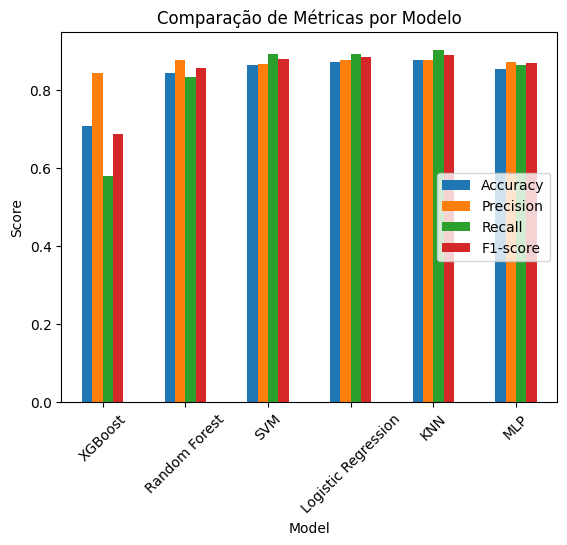

In [ ]:
comparison.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1-score']].plot(kind='bar')
plt.ylabel('Score')
plt.title('Comparação de Métricas por Modelo')
plt.legend(loc='center right')
plt.xticks(rotation=45)
plt.show()

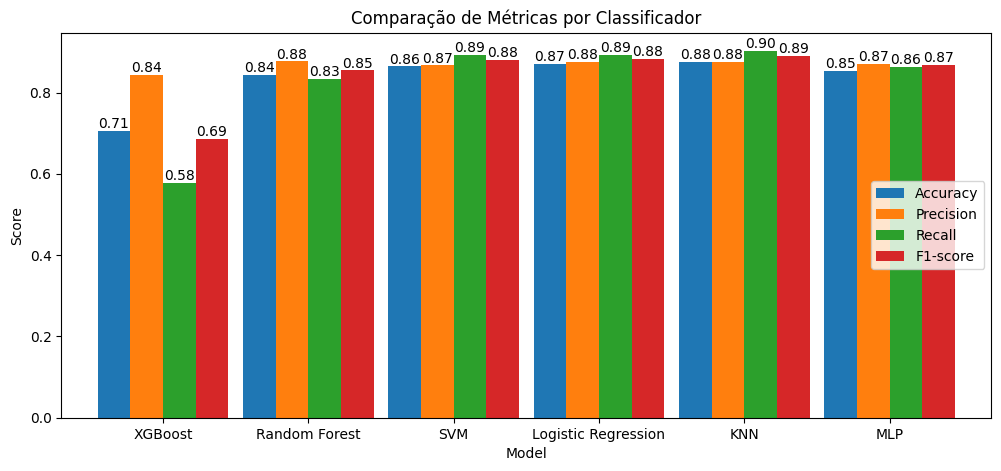

In [ ]:
ax = comparison.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1-score']].plot(
    kind='bar',
    width=0.9,
    figsize=(12, 5)
)

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')

plt.ylabel('Score')
plt.legend(loc='center right')
plt.title('Comparação de Métricas por Classificador')
plt.xticks(rotation=0)
plt.show()

A maioria dos modelos apresenta um desempenho muito consistente e equilibrado, com pontuações situadas na faixa de 0.83 a 0.90. Isso indica que o problema de classificação está sendo bem resolvido por quase todos os algoritmos testados.

Para este cenário, o KNN ou a Regressão Logística seriam as escolhas primárias devido ao alto equilíbrio entre capturar os casos positivos (Recall) e manter a exatidão (Precision).

O baixo desempenho do XGBoost é incomum para esse algoritmo, o que pode sugerir a necessidade de um ajuste de hiperparâmetros (Tuning) ou uma verificação no balanceamento dos dados de treino.